# Imports and Installs

In [0]:
# Downgrate numpy to fix a problem
!pip install numpy==1.16.2

     |████████████████████████████████| 17.3MB 2.6MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.16.3
    Uninstalling numpy-1.16.3:
      Successfully uninstalled numpy-1.16.3


In [0]:
# import the required libraries
import matplotlib.pyplot as plt
import numpy as np
import time
import random
#import cPickle
import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

In [0]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)

INFO:tensorflow:TensorFlow Version: 1.13.1


In [0]:
!pip install -q magenta

In [0]:
# import our command line tools
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



# Data Download

In [0]:
!git clone 'https://github.com/dbt-ethz/home-castle.git'

Cloning into 'home-castle'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 15 (delta 0), reused 12 (delta 0), pack-reused 0
Unpacking objects: 100% (15/15), done.


In [0]:
data_dir = './home-castle/datasets'
models_root_dir = './home-castle/models'
model_dir = './home-castle/models'

# Load Model

In [0]:
def load_env_compatible(data_dir, model_dir):
    """Loads environment for inference mode, used in jupyter notebook."""
    # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
    # to work with depreciated tf.HParams functionality
    model_params = sketch_rnn_model.get_default_hparams()
    with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
        data = json.load(f)
    fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
    for fix in fix_list:
        data[fix] = (data[fix] == 1)
    model_params.parse_json(json.dumps(data))
    return load_dataset(data_dir, model_params, inference_mode=True)

def load_model_compatible(model_dir):
    """Loads model for inference mode, used in jupyter notebook."""
    # modified https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/sketch_rnn_train.py
    # to work with depreciated tf.HParams functionality
    model_params = sketch_rnn_model.get_default_hparams()
    with tf.gfile.Open(os.path.join(model_dir, 'model_config.json'), 'r') as f:
        data = json.load(f)
    fix_list = ['conditional', 'is_training', 'use_input_dropout', 'use_output_dropout', 'use_recurrent_dropout']
    for fix in fix_list:
        data[fix] = (data[fix] == 1)
    model_params.parse_json(json.dumps(data))

    model_params.batch_size = 1  # only sample one at a time
    eval_model_params = sketch_rnn_model.copy_hparams(model_params)
    eval_model_params.use_input_dropout = 0
    eval_model_params.use_recurrent_dropout = 0
    eval_model_params.use_output_dropout = 0
    eval_model_params.is_training = 0
    sample_model_params = sketch_rnn_model.copy_hparams(eval_model_params)
    sample_model_params.max_seq_len = 1  # sample one point at a time
    return [model_params, eval_model_params, sample_model_params]

In [0]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env_compatible(data_dir, model_dir)

INFO:tensorflow:Loaded 70000/2500/2500 from sketchrnn_house.npz
INFO:tensorflow:Loaded 70000/2500/2500 from sketchrnn_castle.npz
INFO:tensorflow:Dataset combined: 150000 (140000/5000/5000), avg len 42
INFO:tensorflow:model_params.max_seq_len 95.
total images <= max_seq_len is 140000
total images <= max_seq_len is 5000
total images <= max_seq_len is 5000
INFO:tensorflow:normalizing_scale_factor 64.6147.


In [0]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

INFO:tensorflow:Model using gpu.
I

In [0]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [0]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model ./home-castle/models/vector-18000.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./home-castle/models/vector-18000


# Helper Functions

In [0]:
def encode(input_strokes):
    strokes = to_big_strokes(input_strokes, max_len=eval_model.hps.max_seq_len).tolist()
    strokes.insert(0, [0, 0, 1, 0, 0])
    seq_len = [len(input_strokes)]
    return sess.run(eval_model.batch_z, feed_dict={eval_model.input_data: [strokes], eval_model.sequence_lengths: seq_len})[0]

In [0]:
def decode(z_input=None, temperature=0.1, factor=0.2):
    z = None
    if z_input is not None:
        z = [z_input]
    sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
    strokes = to_normal_strokes(sample_strokes)
    return strokes

# Visualise

In [0]:
# get a sample drawing from the test set
stroke = test_set.random_sample()

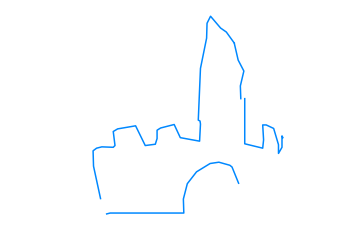

In [0]:
myabssk = strokes_to_lines(stroke)
plt.axis('equal')
plt.axis('off')
for s in myabssk:
    xs = [v[0] for v in s]
    ys = [-v[1] for v in s]
    plt.plot(xs,ys,'#0088ff')

# Encode and Decode

In [0]:
z = encode(stroke)
d = decode(z, temperature=1)

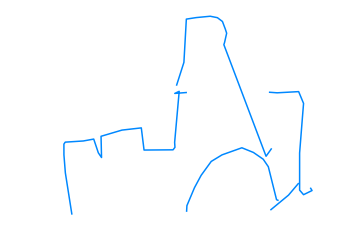

In [0]:
myabssk = strokes_to_lines(d)
plt.axis('equal')
plt.axis('off')
for s in myabssk:
    xs = [v[0] for v in s]
    ys = [-v[1] for v in s]
    plt.plot(xs,ys,'#0088ff')

# Random Samples

In [0]:
# randomly unconditionally generate 10 examples
N = 10
reconstructions = []
for i in range(N):
    reconstructions.append([decode(temperature=0.5), [0, i]])

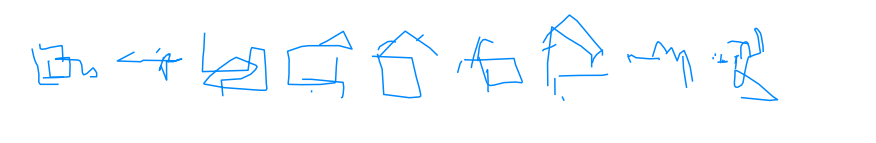

In [0]:
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    myabssk = strokes_to_lines(reconstructions[i][0])
    plt.axis('equal')
    plt.axis('off')
    for s in myabssk:
        xs = [v[0] for v in s]
        ys = [-v[1] for v in s]
        plt.plot(xs,ys,'#0088ff')

# Blend

In [0]:
z_0 = np.random.randn(eval_model.hps.z_size)
z_1 = np.random.randn(eval_model.hps.z_size)

In [0]:
z_list = [] # interpolate spherically between z_0 and z_1
N = 10
for t in np.linspace(0, 1, N):
    z_list.append(slerp(z_0, z_1, t))
# for every latent vector in z_list, sample a vector image
reconstructions = []
for i in range(N):
    reconstructions.append([decode(z_list[i], temperature=0.1), [0, i]])

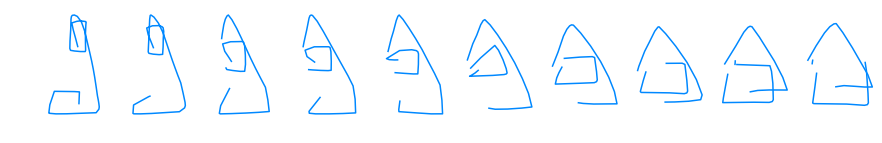

In [0]:
plt.figure(figsize=(15,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    myabssk = strokes_to_lines(reconstructions[i][0])
    plt.axis('equal')
    plt.axis('off')
    for s in myabssk:
        xs = [v[0] for v in s]
        ys = [-v[1] for v in s]
        plt.plot(xs,ys,'#0088ff')

# Exercise

### Schrödinger’s Castle

Explore the VAE model trained on houses and castles and find “sweet spots” in latent space. Generate new house/castle hybrids, either from random or synthetic input or with an existing sketch from the train-, test- or validation-set as a starting point. Use e.g. the dimensionality reduction / clustering presented in the last tutorial to find denser areas or generate stepwise blends. Upload the vector drawings (PDF) together with the notebook containing some comments what the idea was and how you approached it.